In [1]:
import pandas as pd
import numpy as np
from pydataset import data
from scipy import stats
import env
from acquire import get_connection, get_titanic_data, get_iris_data, get_telco_data
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier as DT, plot_tree, export_text

In [2]:
titanic = get_titanic_data()
def dropped(titanic,columns={'sepal_length', 'petal_width'}):
    '''
    dropped will take the dataframe and remove any columns that are indicated,
    hopefully making the process faster
    '''
    titanic = titanic.drop(columns=columns)
    return titanic

In [3]:
def eyes_on(df):
    '''
    eyes_on will take a dataframe and give a summary decription, the top five of that dataframe, and the dtypes of the columns.
    return: df.describe(), df.head(5), df.dtypes
    '''
    return print(f'Summary:\n{df.describe()}\n\n Top 5:\n{df.head()}\n\n DTypes:\n{df.dtypes}')

# Exercises

## Using the titanic data, in your classification-exercises repository, create a notebook, decision_tree.ipynb where you will do the following:

In [4]:
titanic = get_titanic_data()
eyes_on(titanic)

Summary:
       passenger_id    survived      pclass         age       sibsp  \
count    891.000000  891.000000  891.000000  714.000000  891.000000   
mean     445.000000    0.383838    2.308642   29.699118    0.523008   
std      257.353842    0.486592    0.836071   14.526497    1.102743   
min        0.000000    0.000000    1.000000    0.420000    0.000000   
25%      222.500000    0.000000    2.000000   20.125000    0.000000   
50%      445.000000    0.000000    3.000000   28.000000    0.000000   
75%      667.500000    1.000000    3.000000   38.000000    1.000000   
max      890.000000    1.000000    3.000000   80.000000    8.000000   

            parch        fare       alone  
count  891.000000  891.000000  891.000000  
mean     0.381594   32.204208    0.602694  
std      0.806057   49.693429    0.489615  
min      0.000000    0.000000    0.000000  
25%      0.000000    7.910400    0.000000  
50%      0.000000   14.454200    1.000000  
75%      0.000000   31.000000    1.000000  

### What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [5]:
# cleaning up the dataframe
top_embarked = titanic['embark_town'].describe()['top']
titanic['embark_town'] = titanic['embark_town'].fillna(value='Southampton')
titanic = dropped(titanic,columns={'deck', 'pclass', 'embarked', 'class', 'passenger_id'})
titanic['age'] = titanic['age'].fillna(value='30').astype(float)

In [6]:
titanic['label'] = titanic['survived'] == 1

In [7]:
titanic['label'].value_counts()

label
False    549
True     342
Name: count, dtype: int64

In [8]:
eyes_on(titanic)

Summary:
         survived         age       sibsp       parch        fare       alone
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838   29.758889    0.523008    0.381594   32.204208    0.602694
std      0.486592   13.002570    1.102743    0.806057   49.693429    0.489615
min      0.000000    0.420000    0.000000    0.000000    0.000000    0.000000
25%      0.000000   22.000000    0.000000    0.000000    7.910400    0.000000
50%      0.000000   30.000000    0.000000    0.000000   14.454200    1.000000
75%      1.000000   35.000000    1.000000    0.000000   31.000000    1.000000
max      1.000000   80.000000    8.000000    6.000000  512.329200    1.000000

 Top 5:
   survived     sex   age  sibsp  parch     fare  embark_town  alone  label
0         0    male  22.0      1      0   7.2500  Southampton      0  False
1         1  female  38.0      1      0  71.2833    Cherbourg      0   True
2         1  female  26.0      0      0   7.9250  So

In [9]:
titanic['baseline'] = titanic['survived'].value_counts().idxmin()
baseline_accuracy = (titanic.baseline == titanic.survived).mean()
baseline_accuracy

0.3838383838383838

#### Answer: The baseline accuracy for those that survived on the titanic is 38.38%.

### Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

H$_0$ = survival is independent of gender

H$_α$ = survival is dependent on gender

In [10]:
α = 0.05

In [11]:
gender_observed = pd.crosstab(titanic.survived, titanic.sex)
gender_observed

sex,female,male
survived,,
0,81,468
1,233,109


In [12]:
# stats testing to see possible drivers
chi2, p, degf, expected = stats.chi2_contingency(gender_observed)

print(f'chi^2 = {chi2:.4f}') 
print(f'p     = {p:.4f}')

if p < α:
    print('We reject the null hypothesis, it seems survival is dependent of gender.')
else:
    print('We fail to reject the null hypothesis, survival appears independent of gender.')

chi^2 = 260.7170
p     = 0.0000
We reject the null hypothesis, it seems survival is dependent of gender.


In [13]:
town_observed = pd.crosstab(titanic.survived, titanic.embark_town)
town_observed

embark_town,Cherbourg,Queenstown,Southampton
survived,,,
0,75,47,427
1,93,30,219


H$_0$ = survival is independent of embarked town

H$_α$ = survival is dependent on embarked town

In [14]:
# stats testing to see possible drivers
chi2, p, degf, expected = stats.chi2_contingency(town_observed)

print(f'chi^2 = {chi2:.4f}') 
print(f'p     = {p:.4f}')

if p < α:
    print('We reject the null hypothesis, it seems survival is dependent of embarked town.')
else:
    print('We fail to reject the null hypothesis, survival appears independent of embarked town.')

chi^2 = 25.9645
p     = 0.0000
We reject the null hypothesis, it seems survival is dependent of embarked town.


In [15]:
titanic['female'] = (titanic['sex'] == 'female').astype(int)
titanic['embark_town_encoded'] = titanic['embark_town'].map({'Queenstown': 1, 'Southampton': 2, 'Cherbourg': 0})
titanic = titanic.drop(columns='sex')
titanic.head()

,survived,age,sibsp,parch,fare,embark_town,alone,label,baseline,female,embark_town_encoded
0,0,22.0,1,0,7.2500,Southampton,0,False,1,0,2
1,1,38.0,1,0,71.2833,Cherbourg,0,True,1,1,0
2,1,26.0,0,0,7.9250,Southampton,1,True,1,1,2
3,1,35.0,1,0,53.1000,Southampton,0,True,1,1,2
4,0,35.0,0,0,8.0500,Southampton,1,False,1,0,2


In [16]:
train_validate, test = train_test_split(titanic, test_size=0.2, random_state=117, stratify=titanic['survived'])
train, validate = train_test_split(train_validate, test_size=0.3, random_state=117, stratify=train_validate['survived'])

In [17]:
train.shape,validate.shape,test.shape

((498, 11), (214, 11), (179, 11))

In [18]:
train.loc[:,'label'] = train['label'].apply(lambda x: 'Survived' if x else 'Survived Not')
validate.loc[:,'label'] = validate['label'].apply(lambda x: 'Survived' if x else 'Survived Not')
test.loc[:,'label'] = test['label'].apply(lambda x: 'Survived' if x else 'Survived Not')

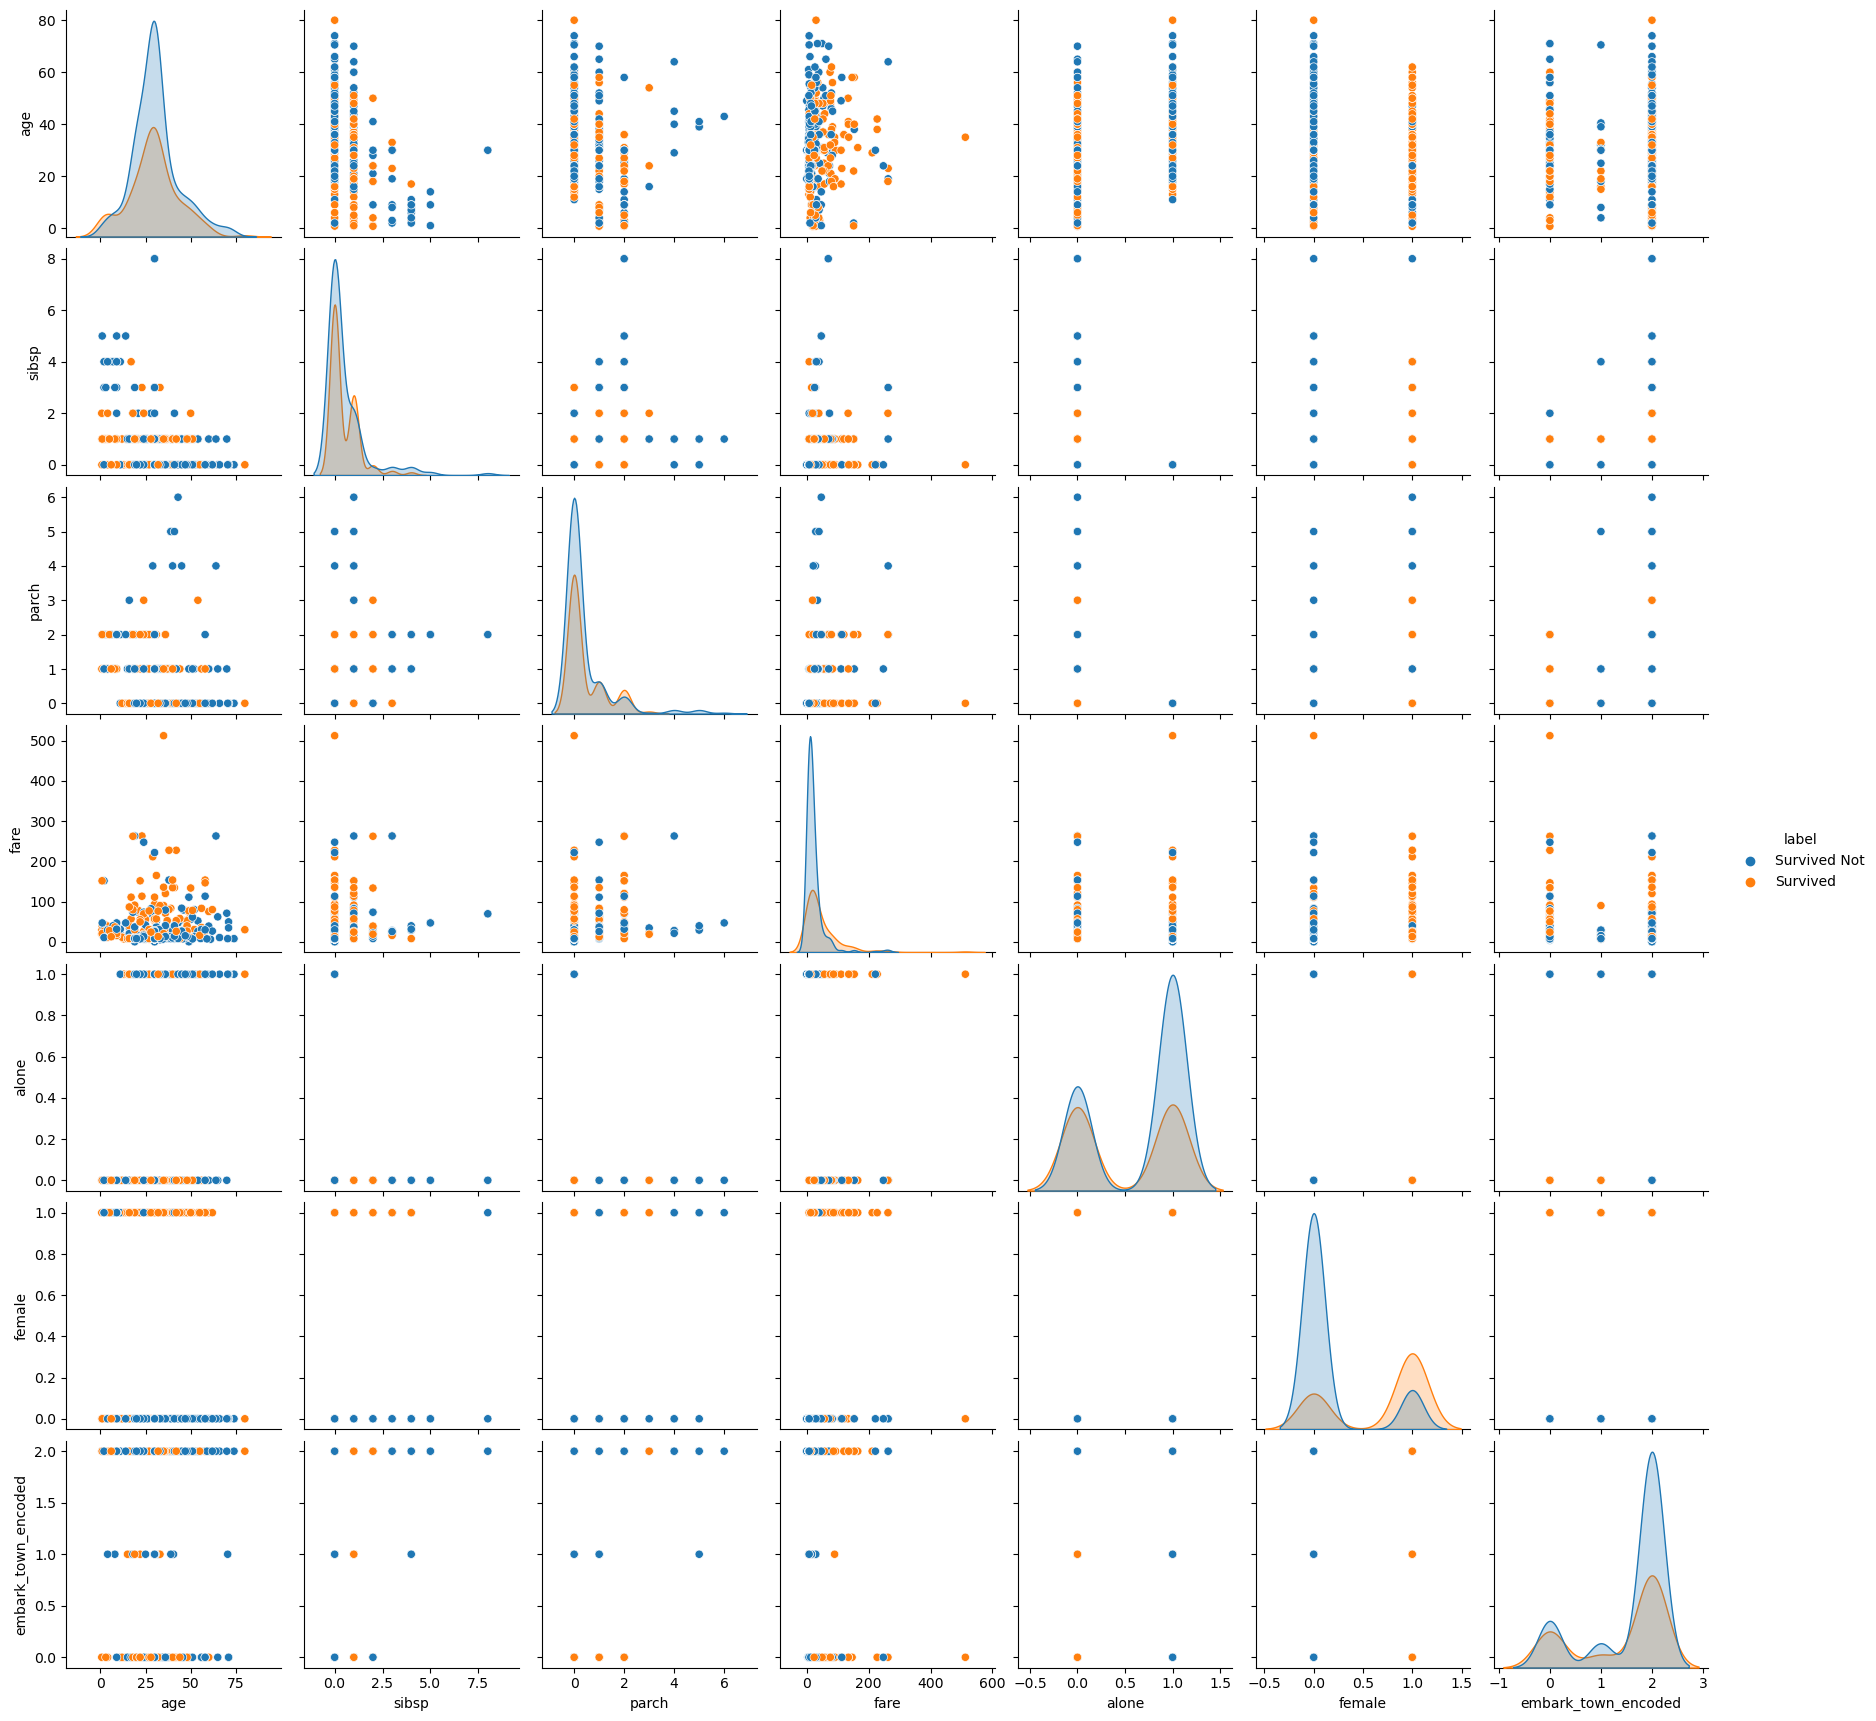

In [19]:
sns.pairplot(data=train.drop(columns={'survived', 'baseline', }), hue='label')
plt.show()

#### Answer: Visually, the largest driver seem to be gender, with a secondary driver of age below 60, finally tertiary I can see are possibly fare and embarked town.

### Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [20]:
# remind me how the data looks again
eyes_on(titanic)

Summary:
         survived         age       sibsp       parch        fare       alone  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838   29.758889    0.523008    0.381594   32.204208    0.602694   
std      0.486592   13.002570    1.102743    0.806057   49.693429    0.489615   
min      0.000000    0.420000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   22.000000    0.000000    0.000000    7.910400    0.000000   
50%      0.000000   30.000000    0.000000    0.000000   14.454200    1.000000   
75%      1.000000   35.000000    1.000000    0.000000   31.000000    1.000000   
max      1.000000   80.000000    8.000000    6.000000  512.329200    1.000000   

       baseline      female  embark_town_encoded  
count     891.0  891.000000           891.000000  
mean        1.0    0.352413             1.536476  
std         0.0    0.477990             0.791503  
min         1.0    0.000000             0.000000  
25%   

In [21]:
clf = DT()
clf

DecisionTreeClassifier()

In [23]:
X_train = train.drop(columns=['survived', 'label', 'embark_town'])
y_train = train['label']

X_validate = validate.drop(columns=['survived', 'label', 'embark_town'])
y_validate = validate['label']

X_test = test.drop(columns=['survived', 'label', 'embark_town'])
y_test = test['label']

clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [24]:
model_1_preds = clf.predict(X_train)

In [25]:
accuracy_score(y_train, model_1_preds)

0.9839357429718876

In [26]:
model_1_val_preds = clf.predict(X_validate)

In [28]:
accuracy_score(y_validate, model_1_val_preds)

0.780373831775701

In [29]:
clf.score(X_train, y_train)

0.9839357429718876

In [30]:
confusion_matrix(y_train, model_1_preds)

array([[190,   1],
       [  7, 300]])

In [32]:
pd.DataFrame(confusion_matrix(y_train, model_1_preds),
             columns=['pred_0', 'pred_1'],
             index=['actual_0', 'actual_1'])

,pred_0,pred_1
actual_0,190,1
actual_1,7,300


In [37]:
clf_1 = DT(max_depth=2)
clf_1.fit(X_train[['female', 'age']], y_train)

DecisionTreeClassifier(max_depth=2)

In [52]:
model_2_preds = clf_1.predict(X_train[['female', 'age']])
results = pd.DataFrame({'actual': y_train.values, 'model_1': model_1_preds, 'model_2': model_2_preds})

In [53]:
model_2_feats = ['female', 'age']
clf_1.score(X_train[model_2_feats], y_train)

0.8052208835341366

In [54]:
pd.DataFrame(classification_report(results['actual'], results['model_2'], output_dict=True)).T

,precision,recall,f1-score,support
Survived,0.758242,0.722513,0.739946,191.000000
Survived Not,0.832278,0.856678,0.844302,307.000000
accuracy,0.805221,0.805221,0.805221,0.805221
macro avg,0.795260,0.789595,0.792124,498.000000
weighted avg,0.803883,0.805221,0.804278,498.000000


In [34]:
print(classification_report(y_train, model_1_preds))

              precision    recall  f1-score   support

    Survived       0.96      0.99      0.98       191
Survived Not       1.00      0.98      0.99       307

    accuracy                           0.98       498
   macro avg       0.98      0.99      0.98       498
weighted avg       0.98      0.98      0.98       498



### Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [35]:
pd.DataFrame(classification_report(y_train, model_1_preds, output_dict=True)).T

,precision,recall,f1-score,support
Survived,0.964467,0.994764,0.979381,191.000000
Survived Not,0.996678,0.977199,0.986842,307.000000
accuracy,0.983936,0.983936,0.983936,0.983936
macro avg,0.980572,0.985982,0.983112,498.000000
weighted avg,0.984324,0.983936,0.983981,498.000000


In [55]:
print(export_text(clf_1, feature_names=model_2_feats))

|--- female <= 0.50
|   |--- age <= 13.00
|   |   |--- class: Survived
|   |--- age >  13.00
|   |   |--- class: Survived Not
|--- female >  0.50
|   |--- age <= 12.00
|   |   |--- class: Survived Not
|   |--- age >  12.00
|   |   |--- class: Survived



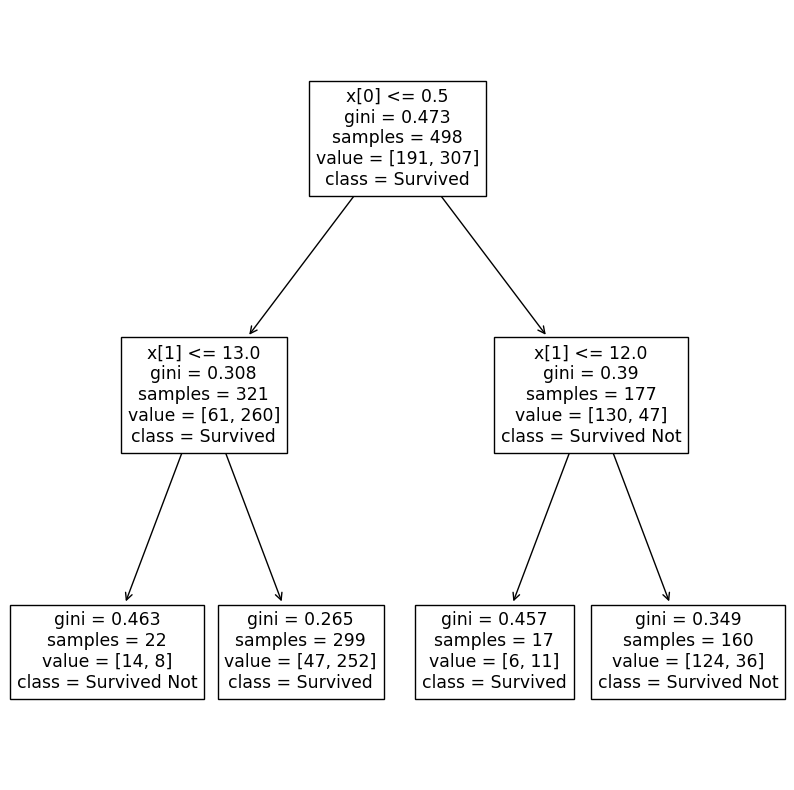

In [59]:
labels = list(y_train.unique())
plt.figure(figsize= (10,10))
plot_tree(clf_1, class_names=labels)
plt.show()

### Run through steps 2-4 using a different max_depth value.

In [60]:
clf_2 = DT(max_depth=4)
clf_2.fit(X_train[['female', 'age']], y_train)

DecisionTreeClassifier(max_depth=4)

In [61]:
model_2_preds = clf_2.predict(X_train[['female', 'age']])
results = pd.DataFrame({'actual': y_train.values, 'model_1': model_1_preds, 'model_2': model_2_preds})

In [62]:
model_2_feats = ['female', 'age']
clf_2.score(X_train[model_2_feats], y_train)

0.821285140562249

In [63]:
pd.DataFrame(classification_report(results['actual'], results['model_2'], output_dict=True)).T

,precision,recall,f1-score,support
Survived,0.786517,0.732984,0.758808,191.000000
Survived Not,0.840625,0.876221,0.858054,307.000000
accuracy,0.821285,0.821285,0.821285,0.821285
macro avg,0.813571,0.804603,0.808431,498.000000
weighted avg,0.819873,0.821285,0.819990,498.000000


In [64]:
print(classification_report(y_train, model_1_preds))

              precision    recall  f1-score   support

    Survived       0.96      0.99      0.98       191
Survived Not       1.00      0.98      0.99       307

    accuracy                           0.98       498
   macro avg       0.98      0.99      0.98       498
weighted avg       0.98      0.98      0.98       498



In [65]:
pd.DataFrame(classification_report(y_train, model_1_preds, output_dict=True)).T

,precision,recall,f1-score,support
Survived,0.964467,0.994764,0.979381,191.000000
Survived Not,0.996678,0.977199,0.986842,307.000000
accuracy,0.983936,0.983936,0.983936,0.983936
macro avg,0.980572,0.985982,0.983112,498.000000
weighted avg,0.984324,0.983936,0.983981,498.000000


In [66]:
print(export_text(clf_2, feature_names=model_2_feats))

|--- female <= 0.50
|   |--- age <= 13.00
|   |   |--- age <= 6.50
|   |   |   |--- age <= 0.96
|   |   |   |   |--- class: Survived
|   |   |   |--- age >  0.96
|   |   |   |   |--- class: Survived
|   |   |--- age >  6.50
|   |   |   |--- age <= 11.50
|   |   |   |   |--- class: Survived Not
|   |   |   |--- age >  11.50
|   |   |   |   |--- class: Survived
|   |--- age >  13.00
|   |   |--- age <= 77.00
|   |   |   |--- age <= 26.50
|   |   |   |   |--- class: Survived Not
|   |   |   |--- age >  26.50
|   |   |   |   |--- class: Survived Not
|   |   |--- age >  77.00
|   |   |   |--- class: Survived
|--- female >  0.50
|   |--- age <= 12.00
|   |   |--- age <= 5.50
|   |   |   |--- age <= 3.50
|   |   |   |   |--- class: Survived Not
|   |   |   |--- age >  3.50
|   |   |   |   |--- class: Survived
|   |   |--- age >  5.50
|   |   |   |--- class: Survived Not
|   |--- age >  12.00
|   |   |--- age <= 47.50
|   |   |   |--- age <= 46.00
|   |   |   |   |--- class: Survived
|   |   |

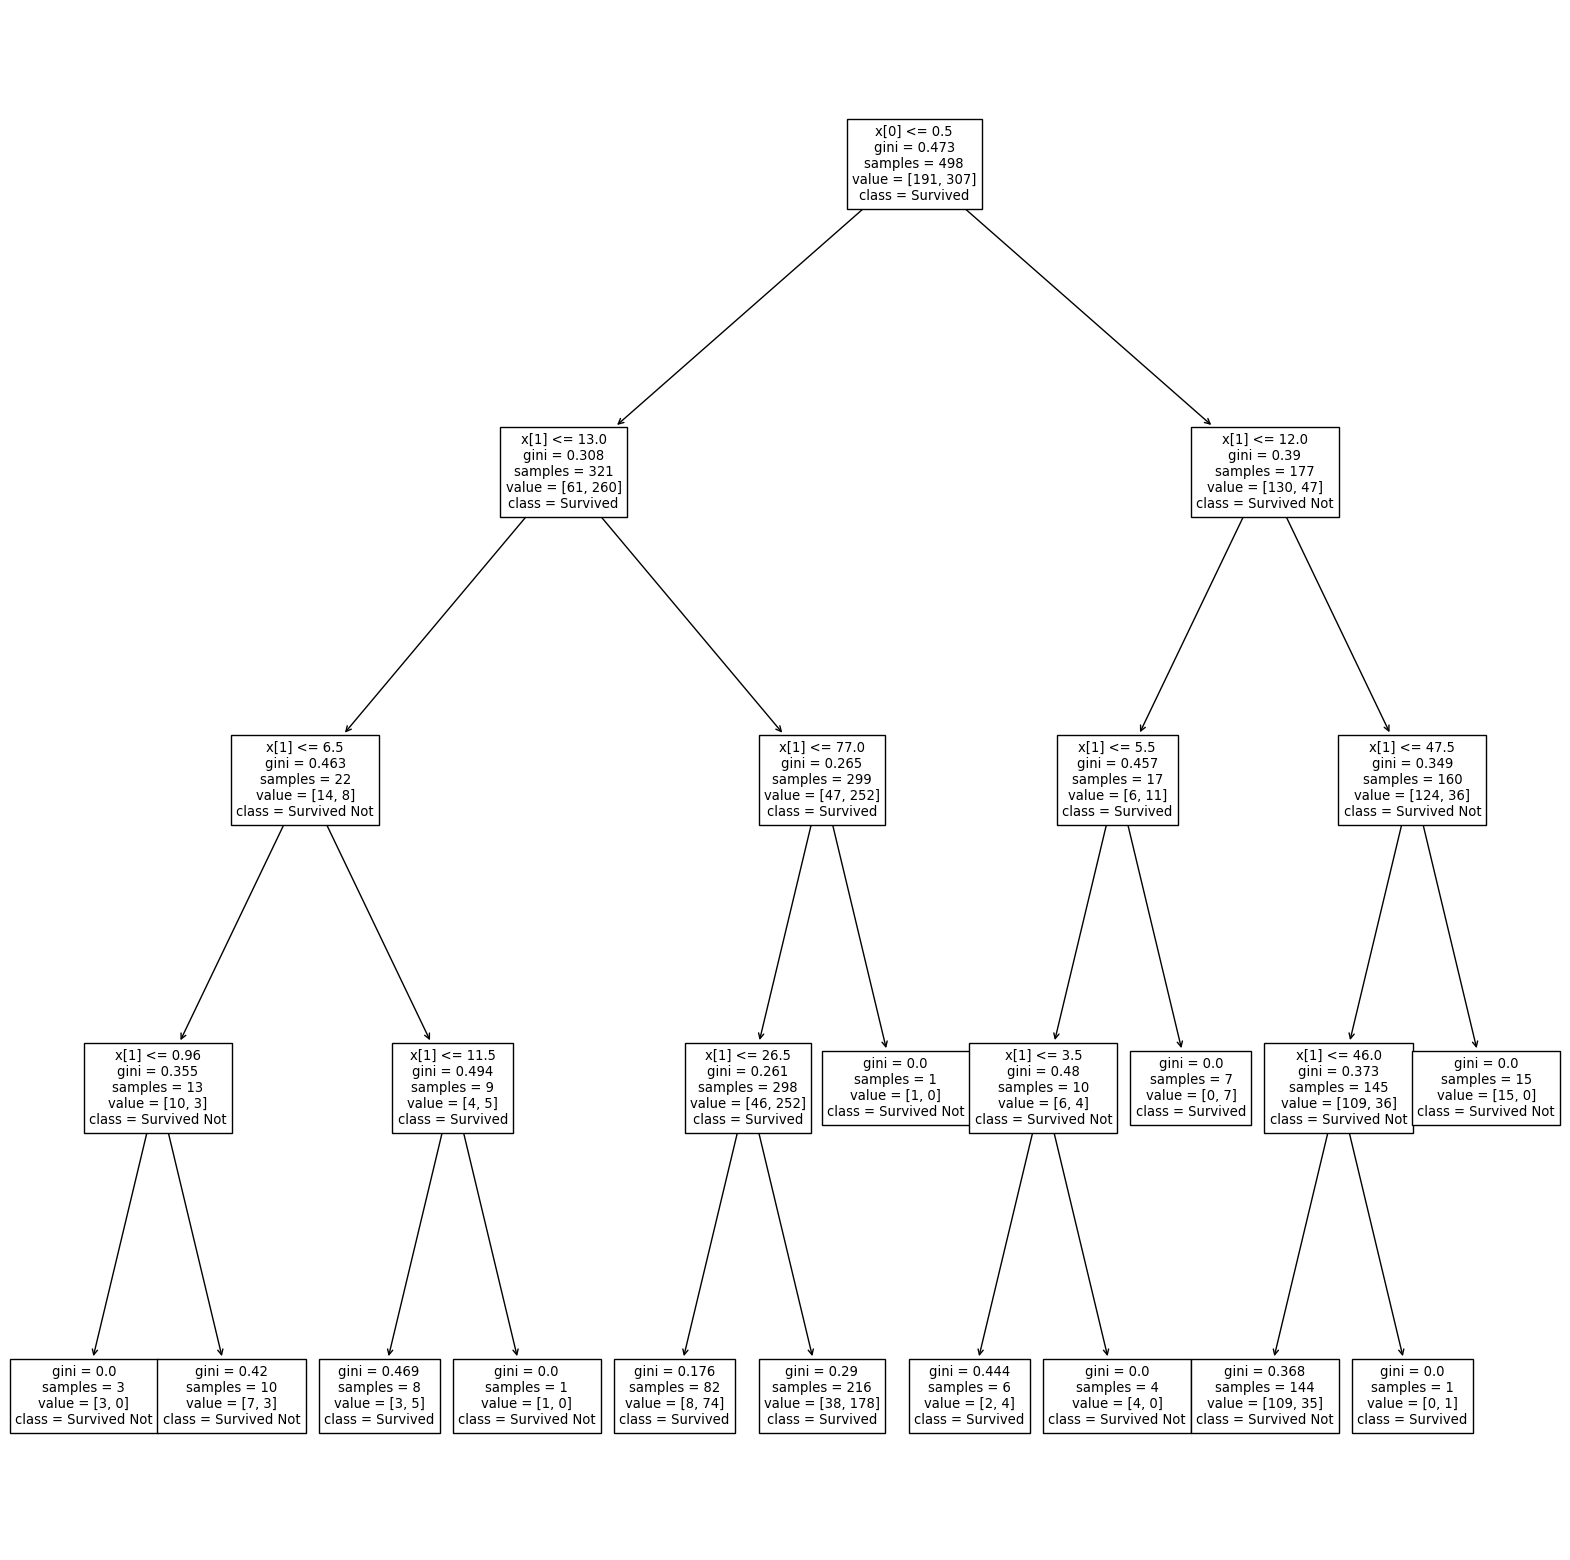

In [68]:
labels = list(y_train.unique())
plt.figure(figsize= (20,20))
plot_tree(clf_2, class_names=labels)
plt.show()

### Which model performs better on your in-sample data?

In [86]:
model_1_train_score = clf_1.score(X_train[model_2_feats], y_train)
model_2_train_score = clf_2.score(X_train[model_2_feats], y_train)

In [129]:
print(f'  Baseline Accuracy is {baseline_accuracy:.2%}\nModel 1 got a score of {model_1_train_score:.2%}\nModel 2 got a score of {model_2_train_score:.2%}')

  Baseline Accuracy is 38.38%
Model 1 got a score of 80.52%
Model 2 got a score of 82.13%


#### Answer: Model 2 did best.

### Which model performs best on your out-of-sample data, the validate set?

In [96]:
clf_1 = DT(max_depth=2)
clf_1.fit(X_validate[['female', 'age']], y_validate)

DecisionTreeClassifier(max_depth=2)

In [106]:
model_1_val_preds = clf.predict(X_validate)
accuracy_score(y_validate, model_1_val_preds)

0.780373831775701

In [107]:
model_1_val_preds = clf_1.predict(X_validate[['female', 'age']])

In [108]:
model_1_val_feats = ['female', 'age']
clf_1.score(X_validate[model_1_val_feats], y_validate)

0.8271028037383178

In [113]:
clf_2 = DT(max_depth=4)
clf_2.fit(X_validate[['female', 'age']], y_validate)

DecisionTreeClassifier(max_depth=4)

In [114]:
model_2_val_preds = clf.predict(X_validate)
accuracy_score(y_validate, model_2_val_preds)

0.780373831775701

In [115]:
model_2_val_preds = clf_2.predict(X_validate[['female', 'age']])

In [116]:
model_2_val_feats = ['female', 'age']
clf_2.score(X_validate[model_2_val_feats], y_validate)

0.8364485981308412

In [117]:
val_results = pd.DataFrame({'actual': y_validate.values, 'model_1': model_1_val_preds, 'model_2': model_2_val_preds})

In [119]:
model_1_val_score = clf_1.score(X_validate[model_2_feats], y_validate)
model_2_val_score = clf_2.score(X_validate[model_2_feats], y_validate)

In [130]:
print(f'  Baseline Accuracy is {baseline_accuracy:.2%}\nModel 1 got a score of {model_1_val_score:.2%}\nModel 2 got a score of {model_2_val_score:.2%}')

  Baseline Accuracy is 38.38%
Model 1 got a score of 82.71%
Model 2 got a score of 83.64%


#### Answer: Model 2 did best.

# Bonus?

## Work through these same exercises using the Telco dataset.

### Experiment with this model on other datasets with a higher number of output classes.